# Inputting User Data using the Hubble Advanced Spectral Products Script

### <span style="font-weight:normal">This Notebook is designed to walk you through downloading and using the **[Hubble Advanced Spectral Products (HASP)](https://archive.stsci.edu/missions-and-data/hst/hasp)** co-add script.</span>

## Learning Goals: 

By the end of this tutorial, you will learn how to:
- Setup a `conda` environment 

- Download the HASP wrapper script

- Use `astroquery.mast` to download COS and STIS data

- Run the co-add script

- Examine the co-added output

- Run the scipt with multiple threshold values and examine output


## Table of Contents
**0. [Introduction](#introduction)**

**1. [Downloading HST Spectroscopic Data](#datadownload)**

\- 1.1 [Using `astroquery` to Download STIS Data](#stisdownload)

**2. [Running the Co-add Script](#runscript)**

**3. [Working with Co-added Data Products](#workwithoutput)**

\- 3.1 [Inspecting the Output Files](#inspectoutput)

\- 3.2 [Viewing Co-added STIS Data](#viewstis)

\- 3.3 [Putting it all together with COS Data](#cos)

**4. [Downloading HASP Data Products](#download_prods)**

\- 4.1 [Downloading Data Products using `astroquery`](#hasp_query)

**5. [Changing the Threshold Flag](#threshold)**

\- 5.1 [Using `Astroquery` to Download Additional Data](#downloadthresh)

\- 5.2 [Running the Co-add Script with Multiple Threshold Values](#threshscriptrun)

\- 5.3 [Analyzing the Co-added Spectra of Different Threshold Values](#analyzethresh)

<a id = introduction></a>
## 0. Introduction

The [Hubble Advanced Spectral Products (HASP) code](https://github.com/spacetelescope/hasp) is a script that co-adds spectra of the same target within programs. This software is able to co-add data taken with the spectrographs onboard the [Hubble Space Telescope (HST)](https://www.stsci.edu/hst); the [Space Telescope Imaging Spectrograph (STIS)](https://www.stsci.edu/hst/instrumentation/stis) and the [Cosmic Origins Spectrograph (COS)](https://www.stsci.edu/hst/instrumentation/cos). The [Hubble Spectroscopic Legacy Archive (HSLA)](https://archive.stsci.edu/missions-and-data/hst/hasp) uses this script to co-add these instruments’ data from [The Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) to create high-quality spectra with a broad wavelength coverage (whenever possible from the ultraviolet to the near-infrared) that is publicly available for the scientific community. These custom co-addition notebooks will instruct users on how to produce their own co-adds in cases where the MAST archive data needs special processing or is rejected by the default filters used in the co-add script.

The script first co-adds the observations for each grating for a given program, then it combines all gratings for the observation set. Finally, it co-adds the spectra of each observation set in the program to produce a fully co-added spectra for each target in a program. Please check out the [COS 2024-01 ISR](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/documentation/instrument-science-reports-isrs/_documents/ISR2024-01.pdf) for more information about HASP. 

This notebook will show users how to download data from MAST, run the co-add script, understand the output files and inspect the abutted data by plotting flux as a function of wavelength. It will also show users how to change the flux threshold flag.

**Please check out our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook before running this tutorial to learn how to install and run the co-add code.**

### Imports

We will be using multiple libraries to retrieve and analyze data. We will use: 
* `Path.pathlib` to create product and data directories 
* `astroquery.mast Observations` to download COS and STIS data
* `shutil` to perform directory and file operations
* `os` to interact with the operating system
* `astropy.io fits` to work with FITS files
* `matplotlib.pyplot` to plot abutted spectra
* `glob` to work with multiple files in our directories
* `subprocesses` to run our script in the notebook with varying threshold flag values
* `numpy` to help analyze our data
* `scipy.interpolate interp1d` to interpolate our data

We recommend creating a HASP-specific `conda` environment when co-adding spectra. You can checkout our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook to create such an environment. Alternatively, you can also download the required dependencies to run this notebook with the terminal command: 

`pip install -r requirements.txt`

This will download the dependencies that are necessary to run this current notebook. Let's import all of our packages that we will use in this notebook and print our `conda` environment by running the next cell:

In [1]:
import os
from pathlib import Path
from astroquery.mast import Observations
import shutil
import glob as glob
from astropy.io import fits
import matplotlib.pyplot as plt
import subprocess
import numpy as np
from scipy.interpolate import interp1d

print("Currently active conda environment:", os.environ.get("CONDA_PREFIX"))

Currently active conda environment: /usr/share/miniconda/envs/hstcal


To do our tutorial, we will create data folders that will contain downloaded data from MAST (one for the STIS and the another for COS). We will also create products folders to contain the HASP script output, a.k.a the co-added spectra. We will have one folder for STIS and another for COS too.

In [2]:
# Creating the data download directories for COS and STIS
stis_data_dir = Path("./stis_data/")
cos_data_dir = Path("./cos_data/")

# Creating the products directory to hold the output
stis_products_dir = Path("./stis_products/")
cos_products_dir = Path("./cos_products/")

# If the directory doesn't exist, then create it
stis_data_dir.mkdir(exist_ok=True)
cos_data_dir.mkdir(exist_ok=True)

stis_products_dir.mkdir(exist_ok=True)
cos_products_dir.mkdir(exist_ok=True)

<a id = datadownload></a>
## 1. Downloading HST Spectroscopic Data

Now that we have a `conda` environment created and the co-add code downloaded, we can start downloading data using `Observations` class from the Python package `astroquery.mast`. Here we will download two datasets, one taken with STIS and the other taken with COS.

<a id = stisdownload></a>
### 1.1 Using `Astroquery` to Download STIS Data

We will be downloading STIS data for the white dwarf [GD71](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=GD+++71); this object is a well-known primary white dwarf standard. We will specifically download data from Program 7656, which has observations of GD71 using the gratings `G230L` and `G140L`.

We can start with querying the MAST database for the STIS program's data. This will give us a list of *all* observations for the program.

In [3]:
# Querying the data on MAST for our target
gd71_query = Observations.query_criteria(
    proposal_id=7656,
    target_name="GD71",
    dataproduct_type="SPECTRUM",
    provenance_name="CALSTIS"
)

Now that we have queried the observations for Program 7656, we can get a list that contains the data products for these observations:

In [4]:
# Getting a product list for our query
gd71_products = Observations.get_product_list(
    gd71_query
)

Let's print out this list to see the associated data files: 

In [5]:
print(gd71_products["productFilename"])

              productFilename              
-------------------------------------------
                         o4a520020_crj.fits
                         o4a520020_jif.fits
                         o4a520020_jit.fits
                         o4a520020_jwf.fits
                         o4a520020_jwt.fits
                         o4a520020_spt.fits
                         o4a520020_trl.fits
                         o4a520020_wav.fits
                         o4a520020_wsp.fits
                         o4a520020_asn.fits
                                        ...
hst_7656_stis_gd71_sg140l_o4a520_cspec.fits
hst_7656_stis_gd71_sg140l_o4a520_cspec.fits
hst_7656_stis_gd71_sg140l_o4a551_cspec.fits
hst_7656_stis_gd71_sg140l_o4a551_cspec.fits
  hst_7656_stis_gd71_sg230l_o4a5_cspec.fits
  hst_7656_stis_gd71_sg230l_o4a5_cspec.fits
hst_7656_stis_gd71_sg230l_o4a520_cspec.fits
hst_7656_stis_gd71_sg230l_o4a520_cspec.fits
hst_7656_stis_gd71_sg230l_o4a551_cspec.fits
hst_7656_stis_gd71_sg230l_o4a551

As you can see, we have a very long list of different type of data products for our program. Luckily, we don't need all of these files to run the wrapper. We only need to download the following COS and/or STIS files:

*    [X1D](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-4-cos-data-products#:~:text=in%20the%20association.-,One%2DDimensional%20Extracted%20Spectra%20(x1d%2C%20x1dsum),-The%20COS%20pipeline) - the one-dimensional extracted product spectra.
  
*    [SX1](https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-2-types-of-stis-files#:~:text=corrected%20imaging%20data.-,_sx1,-table) - the one-dimensional extracted spectra from combined or cosmic-ray rejected images. This file is only produced with STIS data. 

We will specify that we want to download *only* these files with the `productSubGroupDescription` parameter. We will also specify the directory that will contain the downloaded data products. Below, we download the STIS files for the progam.

In [6]:
Observations.download_products(
    gd71_products,
    download_dir=str(stis_data_dir),
    productSubGroupDescription=["X1D", "SX1"]
)

INFO: 54 of 264 products were duplicates. Only downloading 210 unique product(s). [astroquery.mast.observations]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str55,str8,object,object
stis_data/mastDownload/HST/o4a520020/o4a520020_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a520030/o4a520030_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a520040/o4a520040_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a520050/o4a520050_x1d.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a520060/o4a520060_x1d.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a551020/o4a551020_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a551030/o4a551030_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a551040/o4a551040_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a551050/o4a551050_x1d.fits,COMPLETE,None,None


When we downloaded the data using `astroquery`, it created a directory `./stis_data/mastDownload/HST`, with separate folders for each different dataset ID. The script will need all of our newly downloaded data product files in a single directory, so we must move all STIS files to our `./stis_data` directory. We will create a function to consolidate our data, since we will be utilizing it for two additional datasets later on in the tutorial.

In [7]:
def consolidate_files(data_path):
    '''
    Consolidate all files to single directory; necessary for HASP script run.
    ---------------
    Input:
    str data_path : ./mastDownload/HST folders paths; files to be moved here
    ---------------
    Output:
    None. Files moved to data_path. ./mastDownload/HST directory is deleted.
    '''
    # The path to all obs_id folders
    mast_path = f"{data_path}/mastDownload/HST/"

    try:
        # Check if mastDownload exists
        if not os.path.exists(mast_path):
            print(f"Directory {mast_path} doesn't exist.")
            return

        # Get a list of the obs_id paths in mastDownload
        obs_id_dirs = os.listdir(mast_path)

        # Iterate through each obs_id folder and move the files
        for obs_id in obs_id_dirs:
            obs_id_path = os.path.join(mast_path, obs_id)
            files = glob.glob(obs_id_path + "/*fits")

            for file in files:
                file_path = Path(file)
                new_path = data_path / file_path.name
                shutil.move(file, new_path)

        # Now we can remove the mastDownload directory
        if os.path.exists(mast_path):
            shutil.rmtree(f"{data_path}/mastDownload")

    except Exception as e:
        print(f"An error occurred: {e}")

Now, using the function to move our STIS files to a single directory:

In [8]:
consolidate_files(stis_data_dir)

Now we can run the co-add script!

<a id = runscript></a>
## 2. Running the Co-add Script

Now that we've downloaded the GD71 STIS data, we can run the co-add script. Currently, the co-add code abuts spectra for a single program. Run the script by using the next cell's command. 

**Note: Make sure that you are in the `hasp-env` `conda` environment that we created at the beginning of the [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook.**

The `-i` parameter is the input directory (i.e, where the FITS files are located). `-o` is the directory that will contain the newly created co-added products. Note that if you want to exclude certain data files from the co-add, you can just remove them from the input directory. There is more information about this (and the other flags) in our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook.

In [9]:
!swrapper -i ./stis_data -o ./stis_products

HASP version 1.0
Ullyses version 4.1.0


Creating list of unique modes from these files:
./stis_data/o4a520020_sx1.fits GD71 STIS CCD G750L 52X2 7656 (7656, '20')
./stis_data/o4a520030_sx1.fits GD71 STIS CCD G430L 52X2 7656 (7656, '20')
./stis_data/o4a520040_sx1.fits GD71 STIS CCD G230LB 52X2 7656 (7656, '20')
./stis_data/o4a520050_x1d.fits GD71 STIS NUV-MAMA G230L 52X2 7656 (7656, '20')
./stis_data/o4a520060_x1d.fits GD71 STIS FUV-MAMA G140L 52X2 7656 (7656, '20')
./stis_data/o4a551020_sx1.fits GD71 STIS CCD G750L 52X2 7656 (7656, '51')
./stis_data/o4a551030_sx1.fits GD71 STIS CCD G430L 52X2 7656 (7656, '51')
./stis_data/o4a551040_sx1.fits GD71 STIS CCD G230LB 52X2 7656 (7656, '51')
./stis_data/o4a551050_x1d.fits GD71 STIS NUV-MAMA G230L 52X2 7656 (7656, '51')
./stis_data/o4a551060_x1d.fits GD71 STIS FUV-MAMA G140L 52X2 7656 (7656, '51')
Looping over visits
Processing product (7656, '20')
Targets in visit (7656, '20'): ['GD71']
Processing target GD71 in visit (7656, '20')
Processing grating STIS/G750L
Importing files ['./sti

   Wrote ./stis_products/hst_7656_stis_gd71_g750l_o4a520_cspec.fits
Processing grating STIS/G430L
Importing files ['./stis_data/o4a520030_sx1.fits']
Processing file ./stis_data/o4a520030_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./stis_products/hst_7656_stis_gd71_g430l_o4a520_cspec.fits
Processing grating STIS/G230LB
Importing files ['./stis_data/o4a520040_sx1.fits']
Processing file ./stis_data/o4a520040_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
   Wrote ./stis_products/hst_7656_stis_gd71_g230lb_o4a520_cspec.fits
Processing grating STIS/G230L
Importing files ['./stis_data/o4a520050_x1d.fits']
Processing file ./stis_data/o4a520050_x1d.fits
/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/ullyses/coadd.py:550: RuntimeWarning: divide by zero encountered in divide
  weighted_gross = weight_function[self.weighting_method](gross, exptime, net/flux)
Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./stis_products/hst_7656_stis_gd71_sg230l_o4a520_cspec.fits
Processing grating STIS/G140L
Importing files ['./stis_data/o4a520060_x1d.fits']
Processing file ./stis_data/o4a520060_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./stis_products/hst_7656_stis_gd71_sg140l_o4a520_cspec.fits
Making a product from these gratings
STIS/G140L 1138.4-1716.4 (Actual: 1138.4-1711.7)
STIS/G230L 1582.0-3158.7 (Actual: 1583.8-3152.0)
STIS/G230LB 1667.1-3071.6 (Actual: 1670.9-3072.7)
STIS/G430L 2895.9-5704.4 (Actual: 2983.7-5708.0)
STIS/G750L 5261.3-10252.3 (Actual: 5318.5-10256.6)
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/G140L
Abutting STIS/G230L product to current result
With a transition wavelength of 1711.673614241657
Abutting STIS/G430L product to current result
With a transition wavelength of 3151.9512669041987
Abutting STIS/G750L product to current result
With a transition wavelength of 5704.4
Truncating current grating at 10252.3
   Wrote ./stis_products/hst_7656_stis_gd71_sg140l-sg230l-g430l-g750l_o4a520_cspec.fits
Processing product (7656, 

   Wrote ./stis_products/hst_7656_stis_gd71_g750l_o4a551_cspec.fits
Processing grating STIS/G430L
Importing files ['./stis_data/o4a551030_sx1.fits']
Processing file ./stis_data/o4a551030_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./stis_products/hst_7656_stis_gd71_g430l_o4a551_cspec.fits
Processing grating STIS/G230LB
Importing files ['./stis_data/o4a551040_sx1.fits']
Processing file ./stis_data/o4a551040_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./stis_products/hst_7656_stis_gd71_g230lb_o4a551_cspec.fits
Processing grating STIS/G230L
Importing files ['./stis_data/o4a551050_x1d.fits']
Processing file ./stis_data/o4a551050_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
   Wrote ./stis_products/hst_7656_stis_gd71_sg230l_o4a551_cspec.fits
Processing grating STIS/G140L
Importing files ['./stis_data/o4a551060_x1d.fits']
Processing file ./stis_data/o4a551060_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
   Wrote ./stis_products/hst_7656_stis_gd71_sg140l_o4a551_cspec.fits
Making a product from these gratings
STIS/G140L 1138.4-1716.4 (Actual: 1138.8-1717.1)
STIS/G230L 1582.0-3158.7 (Actual: 1581.8-3150.2)
STIS/G230LB 1667.1-3071.6 (Actual: 1670.4-3072.5)
STIS/G430L 2895.9-5704.4 (Actual: 2982.9-5707.7)
STIS/G750L 5261.3-10252.3 (Actual: 5315.9-10254.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/G140L
Abutting STIS/G230L product to current result
With a transition wavelength of 1716.4
Abutting STIS/G430L product to current result
With a transition wavelength of 3150.199723521522
Abutting STIS/G750L product to current result
With a transition wavelength of 5704.4
Truncating current grating at 10252.3
   Wrote ./stis_products/hst_7656_stis_gd71_sg140l-sg230l-g430l-g750l_o4a5

Targets in proposal 7656: ['GD71']
Processing target GD71 in proposal 7656
Processing grating STIS/G750L
Importing files ['./stis_data/o4a520020_sx1.fits', './stis_data/o4a551020_sx1.fits']
Processing file ./stis_data/o4a520020_sx1.fits
Processing file ./stis_data/o4a551020_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./stis_products/hst_7656_stis_gd71_g750l_o4a5_cspec.fits
Processing grating STIS/G430L
Importing files ['./stis_data/o4a520030_sx1.fits', './stis_data/o4a551030_sx1.fits']
Processing file ./stis_data/o4a520030_sx1.fits
Processing file ./stis_data/o4a551030_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./stis_products/hst_7656_stis_gd71_g430l_o4a5_cspec.fits
Processing grating STIS/G230LB
Importing files ['./stis_data/o4a520040_sx1.fits', './stis_data/o4a551040_sx1.fits']
Processing file ./stis_data/o4a520040_sx1.fits
Processing file ./stis_data/o4a551040_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering
   Wrote ./stis_products/hst_7656_stis_gd71_g230lb_o4a5_cspec.fits
Processing grating STIS/G230L
Importing files ['./stis_data/o4a520050_x1d.fits', './stis_data/o4a551050_x1d.fits']
Processing file ./stis_data/o4a520050_x1d.fits
Processing file ./stis_data/o4a551050_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
   Wrote ./stis_products/hst_7656_stis_gd71_sg230l_o4a5_cspec.fits
Processing grating STIS/G140L
Importing files ['./stis_data/o4a520060_x1d.fits', './stis_data/o4a551060_x1d.fits']
Processing file ./stis_data/o4a520060_x1d.fits


Processing file ./stis_data/o4a551060_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./stis_products/hst_7656_stis_gd71_sg140l_o4a5_cspec.fits
Making a product from these gratings
STIS/G140L 1138.4-1716.4 (Actual: 1138.4-1717.4)
STIS/G230L 1582.0-3158.7 (Actual: 1581.8-3151.8)
STIS/G230LB 1667.1-3071.6 (Actual: 1670.4-3072.5)
STIS/G430L 2895.9-5704.4 (Actual: 2982.5-5707.6)
STIS/G750L 5261.3-10252.3 (Actual: 5315.9-10254.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/G140L
Abutting STIS/G230L product to current result
With a transition wavelength of 1716.4
Abutting STIS/G430L product to current result
With a transition wavelength of 3151.7526296530705
Abutting STIS/G750L product to current result
With a transition wavelength of 5704.4
Truncating current grating at 10252.3
   Wrote ./stis_products/hst_7656_stis_gd71_sg140l-sg230l-g430l-g750l_o4a5_cspec.fits


We have now created the co-added products for Program 7656 using the wrapper!

<a id = workwithoutput></a>
## 3. Working with Co-added Data Products

With the newly co-added files in the `./stis_products/output` directory, we can begin to inspect the data.

<a id = inspectoutput></a>
### 3.1 Understanding the Output Files

**_The following information about the output file naming conventions is in our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook. If you're already familiar with this, you can skip to [Section 4.2](viewstis), where we view our co-added spectra._** 

Let's look at the `./stis_products/output` directory to look at the newly abutted spectra. Currently, the script outputs abutted products for a single program.

The script produces multiple different files with abutted spectra. Currently, the script outputs abutted products for a single program. It first creates co-added spectra for each grating of a single observation set:

`hst_programID_instrument_targetname_grating_obset_cspec.fits`

It then co-adds the spectra of all gratings for a single observation set:

`hst_programID_instrument_targetname_allGratings_obset_cspec.fits`

Finally, it co-adds all abutted observation sets' spectra to create a final co-added product for a single target:

`hst_programID_instrument_targetname_allGratings_cspec.fits`

An example of this is below. These filenames are the output files for our STIS GD71 dataset that is co-added in this notebook. Here, the `programID` is `7656`, the `instrument` is `STIS`, and the `targetname` is `gd71`.

| Step | Filename | Description |
|----------|----------|----------|
| 1 | `hst_7656_stis_gd71_g140l_o4a520_cspec.fits` | Co-adding all `G140L` observations for the observation set, `O4A520`. |
| 2 | `hst_7656_stis_gd71_g140l-g230l-g430l-g750l_o4a520_cspec.fits` | Co-adding all observations taken at every grating for the observation set, `O4A520`. |
| 3 | `hst_7656_stis_gd71_g140l-g230l-g430l-g750l_o4a5_cspec.fits` | Co-adding all GD71 observations at each grating for this program, `O4A5`. |

***Note: HST file naming conventions use a combination of three letters and/or numbers to have a unique association between a PI's proposal ID and program ID, meaning that `o4a5` at the end of `hst_7656_stis_gd71_g140l-g230l-g430l-g750l_o4a5_cspec.fits` is essentially the program ID for our example. Check out more information on the [MAST HST file naming convention page](https://archive.stsci.edu/hlsp/ipppssoot.html)*** 

<a id = viewstis></a>
### 3.2 Viewing the Co-added Data

Let's take a look at the co-added spectra that we just created. We will create a plot of flux as a function of wavelength using `matplotlib.pyplot`.

With the current version of the HASP script, the fully abutted filename should be:

`hst_7656_stis_gd71_sg140l-sg230l-g430l-g750l_o4a5_cspec.fits`

Double check your products folder to make sure the name of your fully co-added spectra is the same as above, otherwise the subsequent cells in this notebook will not run since the pathname won't exist. Update and run the cell below with the full co-add filename. 

In [10]:
stis_coadd_filename = "hst_7656_stis_gd71_sg140l-sg230l-g430l-g750l_o4a5_cspec.fits"

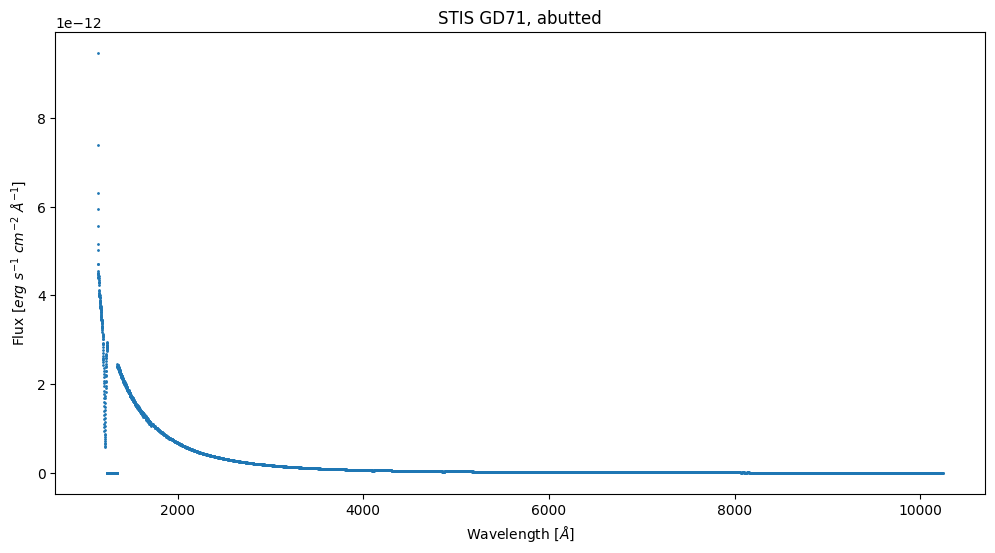

In [11]:
with fits.open(f"./{stis_products_dir}/{stis_coadd_filename}") as hdul:
    # Getting the file's data
    gd71_data = hdul[1].data

    # Getting the wavelength and flux data for the abutted file
    wavelength = gd71_data["WAVELENGTH"]
    flux = gd71_data["FLUX"]

    plt.figure(figsize=(12, 6))

    # Plotting the spectra
    plt.scatter(wavelength, flux,
                # Setting the size of the data points
                s=1)

    # Formatting the plot by adding titles
    plt.title("STIS GD71, abutted")
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    # Saving the figure to the ./stis_products_dir
    plt.savefig(f"{stis_products_dir}/gd71_stis.png")

    # Showing the plot below
    plt.show()

<a id = cos></a>
### 3.3 Putting it all together with COS data

Let's combine all of the STIS work from above and do another example, but this time using COS data instead of STIS. We will use the same target, GD71, and download the data from Program 11479. This has observations of GD71 using the gratings `G230L`, `G185M`, `G225M`, and `G285M`.

In [12]:
# Querying the COS data in MAST and getting the product list
gd71_products = Observations.get_product_list(
    Observations.query_criteria(
        proposal_id=11479,
        target_name="GD71",
        dataproduct_type="SPECTRUM"
    )
)

# Downloading the data to the ./cos_data directory
Observations.download_products(
    gd71_products,
    download_dir=str(cos_data_dir),
    productSubGroupDescription=["X1D", "SX1"]
)

# Consolidating all of our files to a single directory
consolidate_files(cos_data_dir)

INFO: 2848 of 4127 products were duplicates. Only downloading 1279 unique product(s). [astroquery.mast.observations]

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Now we run the wrapper script:

In [13]:
!swrapper -i ./cos_data -o ./cos_products

HASP version 1.0
Ullyses version 4.1.0


Creating list of unique modes from these files:
./cos_data/laad02d9q_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dcq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02deq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dgq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02diq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dkq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dmq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02doq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dqq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dsq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02duq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')


./cos_data/laad02dwq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dyq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02e0q_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02e6q_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02e8q_x1d.fits GD71 COS NUV G185M PSA 11479 (11479, '02')
./cos_data/laad02eaq_x1d.fits GD71 COS NUV G185M PSA 11479 (11479, '02')
./cos_data/laad02edq_x1d.fits GD71 COS NUV G185M PSA 11479 (11479, '02')
./cos_data/laad02efq_x1d.fits GD71 COS NUV G185M PSA 11479 (11479, '02')
./cos_data/laad02ehq_x1d.fits GD71 COS NUV G185M PSA 11479 (11479, '02')
./cos_data/laad02ejq_x1d.fits GD71 COS NUV G185M PSA 11479 (11479, '02')
./cos_data/laad02elq_x1d.fits GD71 COS NUV G185M PSA 11479 (11479, '02')
./cos_data/laad02enq_x1d.fits GD71 COS NUV G185M PSA 11479 (11479, '02')
./cos_data/laad02epq_x1d.fits GD71 COS NUV G185M PSA 11479 (11479, '02')
./cos_data/laad02erq_x1d.fits GD71 COS NUV G185M PS

Processing file ./cos_data/laad02dcq_x1d.fits
Processing file ./cos_data/laad02deq_x1d.fits
Processing file ./cos_data/laad02dgq_x1d.fits
Processing file ./cos_data/laad02diq_x1d.fits
Processing file ./cos_data/laad02dkq_x1d.fits
Processing file ./cos_data/laad02dmq_x1d.fits


Processing file ./cos_data/laad02doq_x1d.fits
Processing file ./cos_data/laad02dqq_x1d.fits
Processing file ./cos_data/laad02dsq_x1d.fits


Processing file ./cos_data/laad02duq_x1d.fits
Processing file ./cos_data/laad02dwq_x1d.fits
Processing file ./cos_data/laad02dyq_x1d.fits
Processing file ./cos_data/laad02e0q_x1d.fits
Processing file ./cos_data/laad02e6q_x1d.fits


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./cos_products/hst_11479_cos_gd71_g225m_laad02_cspec.fits
Processing grating COS/G185M
Importing files ['./cos_data/laad02e8q_x1d.fits', './cos_data/laad02eaq_x1d.fits', './cos_data/laad02edq_x1d.fits', './cos_data/laad02efq_x1d.fits', './cos_data/laad02ehq_x1d.fits', './cos_data/laad02ejq_x1d.fits', './cos_data/laad02elq_x1d.fits', './cos_data/laad02enq_x1d.fits', './cos_data/laad02epq_x1d.fits', './cos_data/laad02erq_x1d.fits', './cos_data/laad02etq_x1d.fits', './cos_data/laad02evq_x1d.fits', './cos_data/laad02exq_x1d.fits', './cos_data/laad02ezq_x1d.fits', './cos_data/laad02f1q_x1d.fits', './cos_data/laad02f3q_x1d.fits', './cos_data/laad02f5q_x1d.fits']
Processing file ./cos_data/laad02e8q_x1d.fits
Processing file ./cos_data/laad02eaq_x1d.fits


Processing file ./cos_data/laad02edq_x1d.fits
Processing file ./cos_data/laad02efq_x1d.fits
Processing file ./cos_data/laad02ehq_x1d.fits
Processing file ./cos_data/laad02ejq_x1d.fits
Processing file ./cos_data/laad02elq_x1d.fits
Processing file ./cos_data/laad02enq_x1d.fits


Processing file ./cos_data/laad02epq_x1d.fits
Processing file ./cos_data/laad02erq_x1d.fits
Processing file ./cos_data/laad02etq_x1d.fits
Processing file ./cos_data/laad02evq_x1d.fits
Processing file ./cos_data/laad02exq_x1d.fits


Processing file ./cos_data/laad02ezq_x1d.fits
Processing file ./cos_data/laad02f1q_x1d.fits
Processing file ./cos_data/laad02f3q_x1d.fits
Processing file ./cos_data/laad02f5q_x1d.fits
/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./cos_products/hst_11479_cos_gd71_g185m_laad02_cspec.fits
Processing grating COS/G285M
Importing files ['./cos_data/laad02f7q_x1d.fits']
Processing file ./cos_data/laad02f7q_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./cos_products/hst_11479_cos_gd71_g285m_laad02_cspec.fits
Processing grating COS/G230L
Importing files ['./cos_data/laad02fdq_x1d.fits', './cos_data/laad02ffq_x1d.fits', './cos_data/laad02fhq_x1d.fits', './cos_data/laad02foq_x1d.fits', './cos_data/laad02frq_x1d.fits', './cos_data/laad02fwq_x1d.fits']
Processing file ./cos_data/laad02fdq_x1d.fits
Processing file ./cos_data/laad02ffq_x1d.fits
Processing file ./cos_data/laad02fhq_x1d.fits
Processing file ./cos_data/laad02foq_x1d.fits
Processing file ./cos_data/laad02frq_x1d.fits


Processing file ./cos_data/laad02fwq_x1d.fits
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L


Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./cos_products/hst_11479_cos_gd71_cg230l_laad02_cspec.fits
Making a product from these gratings
COS/G185M 1664-2134 (Actual: 1662.1-2135.4)
COS/G225M 2069-2526 (Actual: 2068.4-2526.4)
COS/G285M 2474-3221 (Actual: 2967.5-3226.9)
COS/G230L 1650-3200 (Actual: 1327.3-3620.0)
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G230L
Abutting COS/G185M product to current result
With a transition wavelength of 1664
Abutting COS/G225M product to current result
With a transition wavelength of 2134
Abutting COS/G230L product to current result
With a transition wavelength of 2526
Abutting COS/G285M product to current result
With a transition wavelength of 2967.5105517364136
Truncating current grating at 3221


   Wrote ./cos_products/hst_11479_cos_gd71_cg230l-g185m-g225m-g285m_laad02_cspec.fits
Processing product (11479, '03')
Targets in visit (11479, '03'): ['GD71']
Processing target GD71 in visit (11479, '03')
Processing grating COS/G285M
Importing files ['./cos_data/laad03vxq_x1d.fits', './cos_data/laad03vzq_x1d.fits', './cos_data/laad03w4q_x1d.fits', './cos_data/laad03w7q_x1d.fits', './cos_data/laad03w9q_x1d.fits', './cos_data/laad03wbq_x1d.fits', './cos_data/laad03wdq_x1d.fits', './cos_data/laad03wfq_x1d.fits', './cos_data/laad03wmq_x1d.fits', './cos_data/laad03woq_x1d.fits', './cos_data/laad03wqq_x1d.fits', './cos_data/laad03wyq_x1d.fits', './cos_data/laad03xuq_x1d.fits', './cos_data/laad03xyq_x1d.fits', './cos_data/laad03y0q_x1d.fits', './cos_data/laad03y3q_x1d.fits', './cos_data/laad03y5q_x1d.fits', './cos_data/laad03y7q_x1d.fits']
Processing file ./cos_data/laad03vxq_x1d.fits
Processing file ./cos_data/laad03vzq_x1d.fits


Processing file ./cos_data/laad03w4q_x1d.fits
Processing file ./cos_data/laad03w7q_x1d.fits
Processing file ./cos_data/laad03w9q_x1d.fits
Processing file ./cos_data/laad03wbq_x1d.fits
Processing file ./cos_data/laad03wdq_x1d.fits
Processing file ./cos_data/laad03wfq_x1d.fits


Processing file ./cos_data/laad03wmq_x1d.fits
Processing file ./cos_data/laad03woq_x1d.fits
Processing file ./cos_data/laad03wqq_x1d.fits
Processing file ./cos_data/laad03wyq_x1d.fits
Processing file ./cos_data/laad03xuq_x1d.fits


Processing file ./cos_data/laad03xyq_x1d.fits
Processing file ./cos_data/laad03y0q_x1d.fits
Processing file ./cos_data/laad03y3q_x1d.fits


Processing file ./cos_data/laad03y5q_x1d.fits
Processing file ./cos_data/laad03y7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./cos_products/hst_11479_cos_gd71_g285m_laad03_cspec.fits
No need to create abutted product as < 2 single grating products
Looping over proposals
Processing product 11479
Targets in proposal 11479: ['GD71']
Processing target GD71 in proposal 11479
Processing grating COS/G225M
Importing files ['./cos_data/laad02d9q_x1d.fits', './cos_data/laad02dcq_x1d.fits', './cos_data/laad02deq_x1d.fits', './cos_data/laad02dgq_x1d.fits', './cos_data/laad02diq_x1d.fits', './cos_data/laad02dkq_x1d.fits', './cos_data/laad02dmq_x1d.fits', './cos_data/laad02doq_x1d.fits', './cos_data/laad02dqq_x1d.fits', './cos_data/laad02dsq_x1d.fits', './cos_data/laad02duq_x1d.fits', './cos_data/laad02dwq_x1d.fits', './cos_data/laad02dyq_x1d.fits', './cos_data/laad02e0q_x1d.fits', './cos_data/laad02e6q_x1d.fits']
Processing file ./cos_data/laad02d9q_x1d.fits
Processing file ./cos_data/laad02dcq_x1d.fits


Processing file ./cos_data/laad02deq_x1d.fits
Processing file ./cos_data/laad02dgq_x1d.fits
Processing file ./cos_data/laad02diq_x1d.fits
Processing file ./cos_data/laad02dkq_x1d.fits
Processing file ./cos_data/laad02dmq_x1d.fits
Processing file ./cos_data/laad02doq_x1d.fits


Processing file ./cos_data/laad02dqq_x1d.fits
Processing file ./cos_data/laad02dsq_x1d.fits
Processing file ./cos_data/laad02duq_x1d.fits
Processing file ./cos_data/laad02dwq_x1d.fits
Processing file ./cos_data/laad02dyq_x1d.fits
Processing file ./cos_data/laad02e0q_x1d.fits


Processing file ./cos_data/laad02e6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./cos_products/hst_11479_cos_gd71_g225m_laad_cspec.fits
Processing grating COS/G185M
Importing files ['./cos_data/laad02e8q_x1d.fits', './cos_data/laad02eaq_x1d.fits', './cos_data/laad02edq_x1d.fits', './cos_data/laad02efq_x1d.fits', './cos_data/laad02ehq_x1d.fits', './cos_data/laad02ejq_x1d.fits', './cos_data/laad02elq_x1d.fits', './cos_data/laad02enq_x1d.fits', './cos_data/laad02epq_x1d.fits', './cos_data/laad02erq_x1d.fits', './cos_data/laad02etq_x1d.fits', './cos_data/laad02evq_x1d.fits', './cos_data/laad02exq_x1d.fits', './cos_data/laad02ezq_x1d.fits', './cos_data/laad02f1q_x1d.fits', './cos_data/laad02f3q_x1d.fits', './cos_data/laad02f5q_x1d.fits']
Processing file ./cos_data/laad02e8q_x1d.fits


Processing file ./cos_data/laad02eaq_x1d.fits
Processing file ./cos_data/laad02edq_x1d.fits
Processing file ./cos_data/laad02efq_x1d.fits
Processing file ./cos_data/laad02ehq_x1d.fits
Processing file ./cos_data/laad02ejq_x1d.fits


Processing file ./cos_data/laad02elq_x1d.fits
Processing file ./cos_data/laad02enq_x1d.fits
Processing file ./cos_data/laad02epq_x1d.fits
Processing file ./cos_data/laad02erq_x1d.fits
Processing file ./cos_data/laad02etq_x1d.fits
Processing file ./cos_data/laad02evq_x1d.fits


Processing file ./cos_data/laad02exq_x1d.fits
Processing file ./cos_data/laad02ezq_x1d.fits
Processing file ./cos_data/laad02f1q_x1d.fits
Processing file ./cos_data/laad02f3q_x1d.fits
Processing file ./cos_data/laad02f5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./cos_products/hst_11479_cos_gd71_g185m_laad_cspec.fits
Processing grating COS/G285M
Importing files ['./cos_data/laad02f7q_x1d.fits', './cos_data/laad03vxq_x1d.fits', './cos_data/laad03vzq_x1d.fits', './cos_data/laad03w4q_x1d.fits', './cos_data/laad03w7q_x1d.fits', './cos_data/laad03w9q_x1d.fits', './cos_data/laad03wbq_x1d.fits', './cos_data/laad03wdq_x1d.fits', './cos_data/laad03wfq_x1d.fits', './cos_data/laad03wmq_x1d.fits', './cos_data/laad03woq_x1d.fits', './cos_data/laad03wqq_x1d.fits', './cos_data/laad03wyq_x1d.fits', './cos_data/laad03xuq_x1d.fits', './cos_data/laad03xyq_x1d.fits', './cos_data/laad03y0q_x1d.fits', './cos_data/laad03y3q_x1d.fits', './cos_data/laad03y5q_x1d.fits', './cos_data/laad03y7q_x1d.fits']
Processing file ./cos_data/laad02f7q_x1d.fits


Processing file ./cos_data/laad03vxq_x1d.fits
Processing file ./cos_data/laad03vzq_x1d.fits
Processing file ./cos_data/laad03w4q_x1d.fits
Processing file ./cos_data/laad03w7q_x1d.fits
Processing file ./cos_data/laad03w9q_x1d.fits
Processing file ./cos_data/laad03wbq_x1d.fits


Processing file ./cos_data/laad03wdq_x1d.fits
Processing file ./cos_data/laad03wfq_x1d.fits
Processing file ./cos_data/laad03wmq_x1d.fits
Processing file ./cos_data/laad03woq_x1d.fits
Processing file ./cos_data/laad03wqq_x1d.fits


Processing file ./cos_data/laad03wyq_x1d.fits
Processing file ./cos_data/laad03xuq_x1d.fits
Processing file ./cos_data/laad03xyq_x1d.fits
Processing file ./cos_data/laad03y0q_x1d.fits
Processing file ./cos_data/laad03y3q_x1d.fits
Processing file ./cos_data/laad03y5q_x1d.fits


Processing file ./cos_data/laad03y7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./cos_products/hst_11479_cos_gd71_g285m_laad_cspec.fits
Processing grating COS/G230L
Importing files ['./cos_data/laad02fdq_x1d.fits', './cos_data/laad02ffq_x1d.fits', './cos_data/laad02fhq_x1d.fits', './cos_data/laad02foq_x1d.fits', './cos_data/laad02frq_x1d.fits', './cos_data/laad02fwq_x1d.fits']
Processing file ./cos_data/laad02fdq_x1d.fits
Processing file ./cos_data/laad02ffq_x1d.fits
Processing file ./cos_data/laad02fhq_x1d.fits
Processing file ./cos_data/laad02foq_x1d.fits


Processing file ./cos_data/laad02frq_x1d.fits
Processing file ./cos_data/laad02fwq_x1d.fits
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L


Using a maximum SNR of 20.0 in flux-based filtering


   Wrote ./cos_products/hst_11479_cos_gd71_cg230l_laad_cspec.fits
Making a product from these gratings
COS/G185M 1664-2134 (Actual: 1662.1-2135.4)
COS/G225M 2069-2526 (Actual: 2068.4-2526.4)
COS/G285M 2474-3221 (Actual: 2473.8-3226.9)
COS/G230L 1650-3200 (Actual: 1327.3-3620.0)
Starting at the short wavelength end with grating COS/G230L
Abutting COS/G185M product to current result
With a transition wavelength of 1664
Abutting COS/G225M product to current result
With a transition wavelength of 2134
Abutting COS/G285M product to current result
With a transition wavelength of 2526
Truncating current grating at 3221
   Wrote ./cos_products/hst_11479_cos_gd71_cg230l-g185m-g225m-g285m_laad_cspec.fits


Similar to our STIS example, ensure that the filename is updated to the current HASP version by running and/or updating the next cell, then plot the newly abutted COS spectra:

In [14]:
cos_coadd_filename = "hst_11479_cos_gd71_cg230l-g185m-g225m-g285m_laad_cspec.fits"

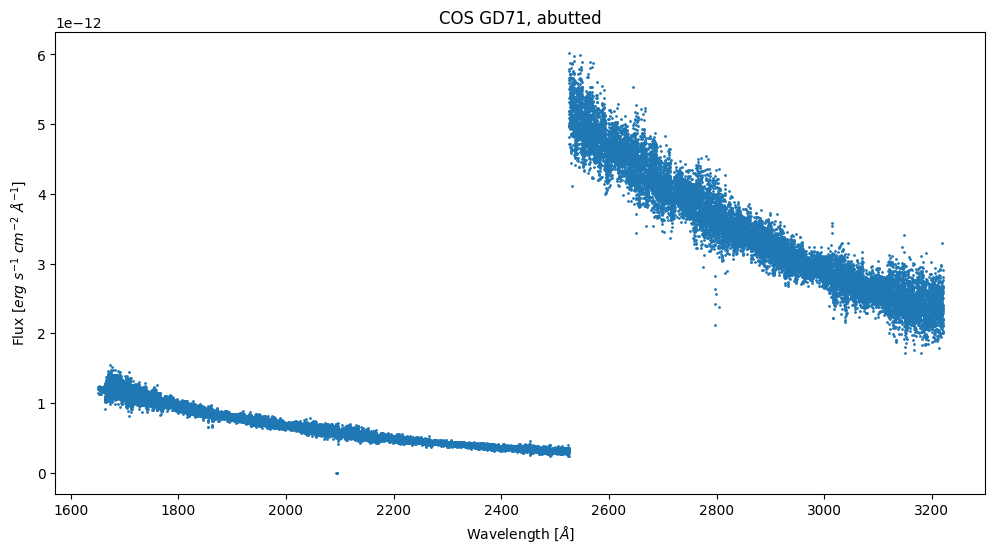

In [15]:
with fits.open(f"./{cos_products_dir}/{cos_coadd_filename}") as hdul:
    # Getting the file's data
    gd71_data = hdul[1].data

    # Getting the wavelength and flux data for the abutted file
    wavelength = gd71_data["WAVELENGTH"]
    flux = gd71_data["FLUX"]

    plt.figure(figsize=(12, 6))

    # Plotting the spectra
    plt.scatter(wavelength, flux,
                s=1)

    # Formatting the plot
    plt.title("COS GD71, abutted")
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    # Saving the figure to ./cos_products
    plt.savefig(f"{cos_products_dir}/gd71_cos.png")

    # Showing the figure below
    plt.show()

We have now created and plotted the abutted COS spectra. Just for fun, let's compare the abutted STIS and COS products!

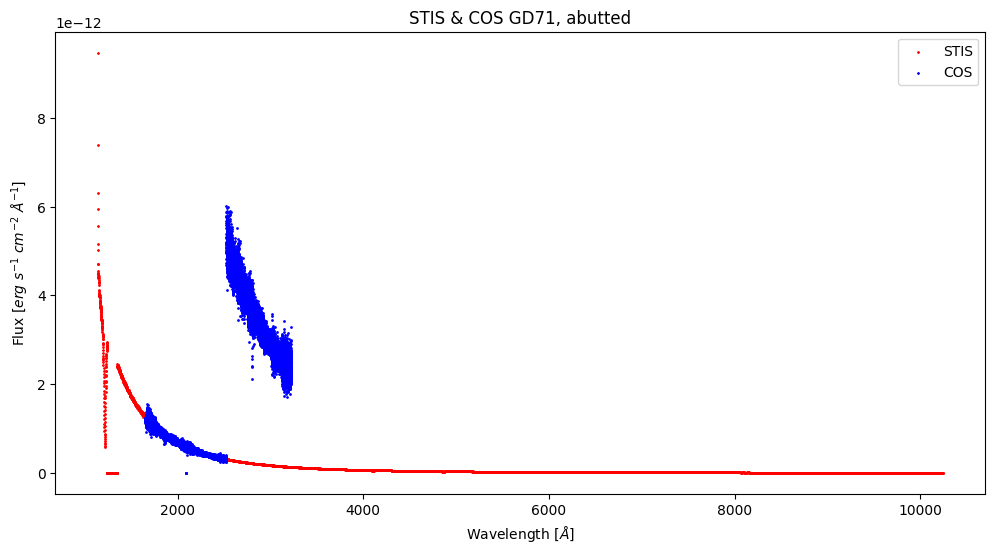

In [16]:
# Getting the COS and STIS data
stis_hdul = fits.open(f"{stis_products_dir}/{stis_coadd_filename}")
stis_data = stis_hdul[1].data

cos_hdul = fits.open(f"{cos_products_dir}/{cos_coadd_filename}")
cos_data = cos_hdul[1].data

# Getting the flux and wavelengths for both files
stis_wavelength = stis_data["WAVELENGTH"]
stis_flux = stis_data["FLUX"]

cos_wavelength = cos_data["WAVELENGTH"]
cos_flux = cos_data["FLUX"]

plt.figure(figsize=(12, 6))

# Plotting datapoints for STIS
plt.scatter(stis_wavelength, stis_flux,
            # Setting the size of the datapoints
            s=1,
            # Setting the color for the STIS datapoints
            color="red",
            # Adding a label for the legend
            label="STIS")

# Plotting the datapoints for COS
plt.scatter(cos_wavelength, cos_flux,
            s=1,
            color="blue",
            label="COS")

# Formatting the plot by adding labels
plt.title("STIS & COS GD71, abutted")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

# Adding a legend to the plot
plt.legend()

# Saving the figure to our general directory
plt.savefig("./gd71_cos_stis.png")

# Showing the plot below
plt.show()

stis_hdul.close()
cos_hdul.close()

<a id = download_prods></a>
## 4. Downloading HASP Data Products

As of January 2024, the HASP data products are available for download via `astroquery`. The products will also be available for query and download on the official HASP web search form (still a work in progress at the time of this notebook's publishing).

Users can download coadded data themselves; we will show an example of this with a STIS coadd. 

<a id = hasp_query></a>
### 4.1 Downloading Data Products using `astroquery`

We can use `astroquery.mast`'s `Observations` module to download data products, similar to how we downloaded our STIS and COS data in [Section 1.1](#stisdownload) and [Section 3.3](#cos), respectively. Let's download GD71 coadds for the STIS example that we created in the previous section.

In [17]:
stis_query = Observations.query_criteria(
    proposal_id=7656,
    target_name="GD71",
    dataproduct_type="SPECTRUM",
)

display(stis_query)

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str3,str7,str13,str4,str6,str10,str4,str48,str28,float64,float64,str8,str16,int64,float64,float64,float64,float64,float64,str47,float64,str4,str8,int64,str192,str64,str63,str6,bool,float64,str9,str9
science,HST,CALSTIS,STIS/CCD,HST,G430L,Optical,GD71,STAR;DA;;CALIBRATION;INSTRUMENT SENSITIVITY TEST,o4a551030,88.11493605595,15.8871153995,spectrum,"Leitherer, Claus",3,51121.355207326385,51121.35849436343,240.0,290.0,570.0,"STIS Spectroscopic and Imaging Sensitivity, CCD",51121.59832169,7656,CAL/STIS,--,POLYGON 88.1207248829903 15.891926933957105 88.1210911230215 15.891486248744052 88.10930728999202 15.882426918902873 88.10894104996083 15.882867604115926 88.1207248829903 15.891926933957105,mast:HST/product/o4a551030_sx1.png,mast:HST/product/o4a551030_sx1.fits,PUBLIC,False,nan,24913536,361280128
science,HST,CALSTIS,STIS/NUV-MAMA,HST,G230L,UV,GD71,STAR;DA;;CALIBRATION;INSTRUMENT SENSITIVITY TEST,o4a520050,88.11494519341,15.88709104568,spectrum,"Leitherer, Claus",3,51291.77992079861,51291.78570783565,500.0,157.0,318.0,"STIS Spectroscopic and Imaging Sensitivity, CCD",51294.74307864,7656,CAL/STIS,--,POLYGON 88.11230375078243 15.884541739081136 88.11192199891019 15.884970073233198 88.11749049251516 15.889561085581292 88.1178722443874 15.88913275142923 88.11230375078243 15.884541739081136,--,--,PUBLIC,False,nan,24913532,361280890
science,HST,CALSTIS,STIS/CCD,HST,G750L,Optical,GD71,STAR;DA;;CALIBRATION;INSTRUMENT SENSITIVITY TEST,o4a520020,88.11494518989,15.88709105505,spectrum,"Leitherer, Claus",3,51291.714503738425,51291.72542986111,900.0,524.0,1027.0,"STIS Spectroscopic and Imaging Sensitivity, CCD",51294.74393508,7656,CAL/STIS,--,POLYGON 88.10933149520822 15.882091238510746 88.10894974331077 15.88251957264204 88.12040330953921 15.891962605844892 88.12078506143666 15.891534271713597 88.10933149520822 15.882091238510746,mast:HST/product/o4a520020_sx1.png,mast:HST/product/o4a520020_sx1.fits,PUBLIC,False,nan,24913529,361280897
science,HST,CALSTIS,STIS/NUV-MAMA,HST,G230L,UV,GD71,STAR;DA;;CALIBRATION;INSTRUMENT SENSITIVITY TEST,o4a551050,88.11493605873,15.88711539207,spectrum,"Leitherer, Claus",3,51121.40708252315,51121.41286956018,500.0,157.0,318.0,"STIS Spectroscopic and Imaging Sensitivity, CCD",51121.59276609,7656,CAL/STIS,--,POLYGON 88.11766692747231 15.889575989863083 88.11803316756908 15.889135304700462 88.11230410581945 15.884730840110846 88.11193786572268 15.885171525273467 88.11766692747231 15.889575989863083,--,--,PUBLIC,False,nan,24913538,361280913
science,HST,CALSTIS,STIS/CCD,HST,G750L,Optical,GD71,STAR;DA;;CALIBRATION;INSTRUMENT SENSITIVITY TEST,o4a551020,88.11493605515,15.88711540161,spectrum,"Leitherer, Claus",3,51121.3404503125,51121.35137642361,900.0,524.0,1027.0,"STIS Spectroscopic and Imaging Sensitivity, CCD",51121.71337958,7656,CAL/STIS,--,POLYGON 88.12072488219037 15.891926936067104 88.12109112222156 15.89148625085405 88.10930728919196 15.882426921012872 88.10894104916076 15.882867606225926 88.12072488219037 15.891926936067104,mast:HST/product/o4a551020_sx1.png,mast:HST/product/o4a551020_sx1.fits,PUBLIC,False,nan,24913535,361280916
science,HST,CALSTIS,STIS/CCD,HST,G230LB,UV,GD71,STAR;DA;;CALIBRATION;INSTRUMENT SENSITIVITY TEST,o4a551040,88.11493605814,15.88711539365,spectrum,"Leitherer, Claus",3,51121.39616809028,51121.40246420139,500.0,168.0,306.0,"STIS Spectroscopic and Imaging Sensitivity, CCD",51121.60144667,7656,CAL/STIS,--,POLYGON 88.12072488518015 15.891926928107104 88.12109112521132 15.89148624289405 88.1093072921822 15.882426913052871 88.10894105215101 15.882867598265925 88.12072488518015 15.891926928107104,mast:HST/product/o4a551040_sx1.png,mast:HST/product/o

We can see that our query returned a total of 11 datasets. We can see our HASP coadd is at the bottom of the table, with the value for `project` being `HASP` instead of `HST`. We will add these criteria to our query to isolate our product. 

In [18]:
stis_query = Observations.query_criteria(
    proposal_id=7656,
    target_name="GD71",
    dataproduct_type="SPECTRUM",
    project="HASP"
)

display(stis_query)

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str3,str4,str4,str4,str6,str10,str4,str1,str28,float64,float64,str8,str16,int64,float64,float64,float64,float64,float64,str1,float64,str4,str4,int64,str61,str64,str63,str6,bool,float64,str9,str9
science,HST,HASP,STIS,HASP,G230LB,UV;OPTICAL,GD71,--,hst_hasp_7656_stis_gd71_o4a5,88.11494062533335,15.887103220149724,spectrum,"Leitherer, Claus",2,51121.396157407406,51291.775300925925,1000.0,168.4,306.6,--,51535.6833332,7656,HASP,--,CIRCLE 88.114940625475 15.887103220455 0.00034722222222222224,mast:HST/product/hasp/hst_7656_stis_gd71_g230lb_o4a520_cspec.png,mast:HST/product/hasp/hst_7656_stis_gd71_g230lb_o4a5_cspec.fits,PUBLIC,False,nan,199242749,432488514


Now, let's see our product list:

In [19]:
stis_prodlist = Observations.get_product_list(
    stis_query
)

# Print number of product files that can be downloaded
print(f"Number of files: {len(stis_prodlist)}\n")

# Printing the entire product list
stis_prodlist.pprint_include_names = ("productFilename", "obs_id", "description", "productType", "productSubGroupDescription", "proposal_id")

display(stis_prodlist)

Number of files: 86



obs_id,description,productType,productSubGroupDescription,proposal_id,productFilename
str28,str62,str9,str5,str4,str62
o4a520040,DADS ASN file - Association ACS/WFC3/STIS,AUXILIARY,ASN,7656,o4a520040_asn.fits
o4a520040,DADS CRJ file - CR-rejected image ACS/WFC3/STIS-CCD,AUXILIARY,CRJ,7656,o4a520040_crj.fits
o4a520040,DADS JIF file,AUXILIARY,JIF,7656,o4a520040_jif.fits
o4a520040,DADS JIT file,AUXILIARY,JIT,7656,o4a520040_jit.fits
o4a520040,DADS JWF file,AUXILIARY,JWF,7656,o4a520040_jwf.fits
o4a520040,DADS JWT file,AUXILIARY,JWT,7656,o4a520040_jwt.fits
o4a520040,DADS SPT file - Engineering telemetry ACS/WFC3/NICMOS/COS/STIS,AUXILIARY,SPT,7656,o4a520040_spt.fits
o4a520040,DADS TRL file - Processing log,AUXILIARY,TRL,7656,o4a520040_trl.fits
o4a520040,DADS WAV file - Raw wavecal exposure STIS,AUXILIARY,WAV,7656,o4a520040_wav.fits


We have 68 files that we can download for our dataset! There are many different file types, auxiliary files such as support (`SPT`), jitter (`JIT`), wavecal exposures (`WAV`), previews of the spectra in `.PNG` format, and our science files (to name a few). Note that the files with a `productSubGroupDescription` value not equal to `CSPEC` are files that are used by `CALSTIS` during data calibration (meaning they are not produced by the HASP coadd script). The science files consist of the `SX1` files which we downloaded when running the coadd script, and the actual coadds themselves (both intermediate and final). Let's just download the `Minimum Recommended Product` files after we create directories to store them by setting `mrp_only = True`. 

**Note that the minimum recommended product filetypes are different depending on if you are downloading a HASP dataset or a non-HASP dataset, e.g. HASP will not include the `SX1` files but downloading a science dataset would.**

In [20]:
# To store our astroquery example STIS and COS data
stis_astroquery = Path("./stis_astroquery/")
stis_astroquery.mkdir(exist_ok=True)

In [21]:
# Downloading the products to our new directory
Observations.download_products(
    stis_prodlist,
    download_dir=str(stis_astroquery),
    mrp_only=True
)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str124,str8,object,object
stis_astroquery/mastDownload/HST/hst_hasp_7656_stis_gd71_o4a5/hst_7656_stis_gd71_g230lb_o4a520_cspec.fits,COMPLETE,None,None
stis_astroquery/mastDownload/HST/hst_hasp_7656_stis_gd71_o4a5/hst_7656_stis_gd71_g230lb_o4a551_cspec.fits,COMPLETE,None,None
stis_astroquery/mastDownload/HST/hst_hasp_7656_stis_gd71_o4a5/hst_7656_stis_gd71_g230lb_o4a5_cspec.fits,COMPLETE,None,None
stis_astroquery/mastDownload/HST/hst_hasp_7656_stis_gd71_o4a5/hst_7656_stis_gd71_g430l_o4a520_cspec.fits,COMPLETE,None,None
stis_astroquery/mastDownload/HST/hst_hasp_7656_stis_gd71_o4a5/hst_7656_stis_gd71_g430l_o4a551_cspec.fits,COMPLETE,None,None
stis_astroquery/mastDownload/HST/hst_hasp_7656_stis_gd71_o4a5/hst_7656_stis_gd71_g430l_o4a5_cspec.fits,COMPLETE,None,None
stis_astroquery/mastDownload/HST/hst_hasp_7656_stis_gd71_o4a5/hst_7656_stis_gd71_g750l_o4a520_cspec.fits,COMPLETE,None,None
stis_astroquery/mastDownload/HST/hst_hasp_7656_stis_gd71_o4a5/hst_7656_stis_gd71_g750l_o4a551_cspec.fits,COMPLETE,None,None
stis_astroquery/mastDownload/HST/hst_hasp_7656_stis_gd71_o4a5/hst_7656_stis_gd71_g750l_o4a5_cspec.fits,COMPLETE,None,None


In [22]:
# Putting all files to the stis_astroquery directory, rather than MAST's nested directories
consolidate_files(stis_astroquery)

We've downloaded the HASP products, so let's plot them now:

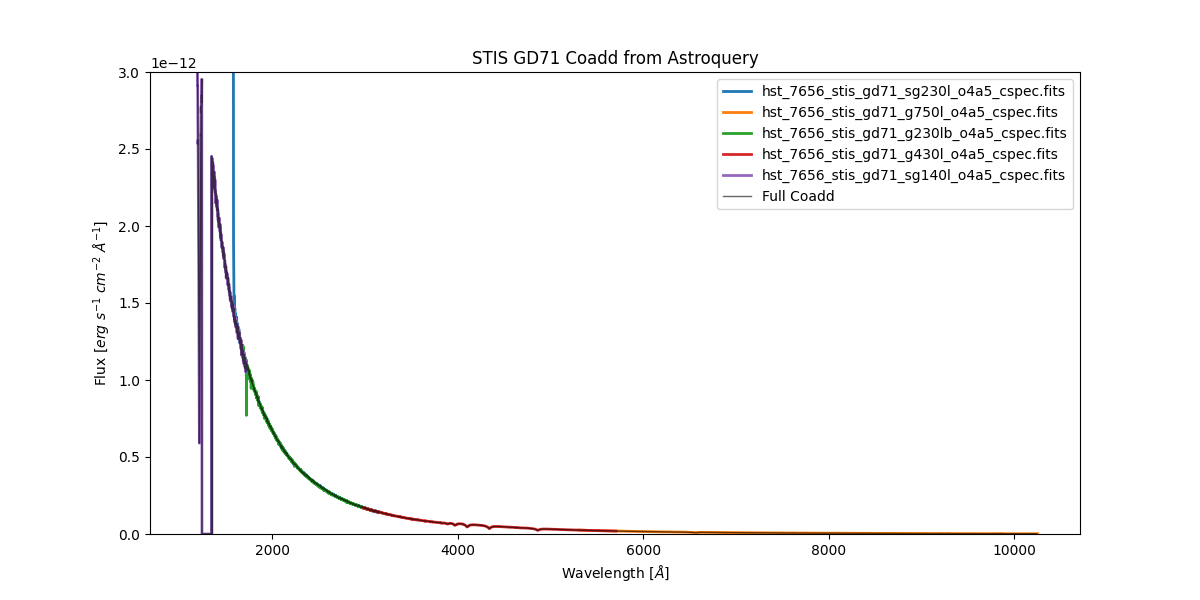

In [23]:
%matplotlib widget

# The name of the full coadd (same filename that we have in Section 3.2)
stis_coadd_filename = "hst_7656_stis_gd71_sg140l-sg230l-g430l-g750l_o4a5_cspec.fits"
stis_coadd_path = f"./{stis_astroquery}/{stis_coadd_filename}"

full_coadd_hdul = fits.open(stis_coadd_path)

# List of coadd files for a single grating (ignoring the full coadd above)
grat_coadds = [f for f in glob.glob(f"./{stis_astroquery}/*_o4a5_*") if f != stis_coadd_path]

# Starting to plot
plt.figure(figsize=(12, 6))

# Plotting the coadd for each grating
for file in grat_coadds:
    file_hdul = fits.open(file)
    data = file_hdul[1].data
    wl = data["WAVELENGTH"].flatten()
    flux = data["FLUX"].flatten()

    plt.plot(wl, flux,
             lw=2,
             label=file.split("/")[-1])
    
    file_hdul.close()
    
# Plotting full coadd over the plot
data = full_coadd_hdul[1].data

wl = data["WAVELENGTH"].flatten()
flux = data["FLUX"].flatten()

plt.plot(wl, flux,
         lw=1,
         color="black",
         alpha=0.6,
         label="Full Coadd")

# Formatting the plot
plt.title("STIS GD71 Coadd from Astroquery")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

plt.legend()

# Setting ylimit to better show spectral features
plt.ylim(0, 3e-12)

plt.show()

full_coadd_hdul.close()

In [24]:
# Closing the plot to save memory
plt.close()

Click the rectangular box on the left hand side of the plot to zoom into specific portions of the plot -- you will be able to see each grating's caodd against the final full coadd. Cool!

<a id = threshold></a>
## 5. Changing the Threshold Flag

The flux threshold flag is an optional flag that can be used to change the number of files that are co-added based on the flux of each spectra. When determining which files to abut, the script first creates a general co-add using all of the input files, and then iterates through each file to calculate the scaled median deviation. The script rejects a file if: 

$$
\left\langle{\frac{F_{x1d}(i) - F_{coadd(i)}}{\sigma_{x1d}(i)}}\right\rangle{} < \frac{C_{thresh}}{\sqrt{N_{pix}}}
$$

In the equation, the median deviation from the co-add is $F_{x1d}(i) - F_{coadd(i)}$, the uncertainty per
wavelength bin of the input spectrum is $\sigma_{x1d}(i)$ and $N_{pix}$ is the number of wavelength bins for a given mode. Essentially, the scaled median deviation is the dispersion that quantifies the data quality (DQ) flag pixel spread for a spectrum that is less sensitive to outliers and size variations. The script will reject all files containing segments with scaled median deviation less than (i.e. more negative than) the threshold (the default is -50). For example, raising the threshold to -25 will abut less files than the default threshold of -50. Likewise, lowering the threshold to -100 will include more files in the dataset to be co-added. 

An important thing to note about changing the threshold is that including more files increases the SNR of your co-added spectra but decreases the flux accuracy. The threshold value may be altered if a user's science case is not dependent on the accuracy of a dataset's absolute flux. For example, if you have a large dataset of a bright target (i.e. a standard star), then you can lower the threshold to include more files in the abutment since the spread of data quality between each file is minimal. Conversely, if you have a dataset of a dim target, or a dataset with many poor observations, then you will want to raise the threshold to only include the best data out of the dataset.

More information about the flux checking algorithm can be found in Section 2.3.2 of the [ISR COS 2024-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/documentation/instrument-science-reports-isrs/_documents/ISR2024-01.pdf).

<a id = downloadthresh></a>
## 5.1 Downloading the Data

We will first download an additional dataset to illustrate how the co-add code changes abutment when the threshold flag is changed. We will download data for the spectroscopic binary, [BD+17D4708](https://simbad.cds.unistra.fr/simbad/sim-coo?Coord=332.88126259897996+18.092873506782&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin&submit=submit+query&CoordList=) from Program 9631. We will run the script with three different threshold values: `t = -1, -2, -50`.

First we will query and download the data using `Observations` from `astroquery.mast`:

In [25]:
# Querying out data from MAST
bd_query = query = Observations.query_criteria(
            proposal_id=9631,
            target_name="BD+17D4708",
            dataproduct_type="SPECTRUM",
            provenance_name=["CALCOS", "CALSTIS"]
        )

print(f"The number of datasets queried is {str(len(bd_query))} datasets. \
      The query list is printed below:")
print(bd_query)

The number of datasets queried is 12 datasets.       The query list is printed below:
intentType obs_collection provenance_name ... srcDen  obsid     objID  
---------- -------------- --------------- ... ------ -------- ---------
   science            HST         CALSTIS ...    nan 24947039 361629326
   science            HST         CALSTIS ...    nan 24947037 361629331
   science            HST         CALSTIS ...    nan 24947036 361629335
   science            HST         CALSTIS ...    nan 24947038 361629336
   science            HST         CALSTIS ...    nan 24947034 361629339
   science            HST         CALSTIS ...    nan 24947033 361629342
   science            HST         CALSTIS ...    nan 24947031 361629346
   science            HST         CALSTIS ...    nan 24947028 361629348
   science            HST         CALSTIS ...    nan 24947026 361629365
   science            HST         CALSTIS ...    nan 24947027 361629366
   science            HST         CALSTIS ...    n

Let's create a new directory and download our data.

In [26]:
# Creating the data download directories
bd_data_dir = Path("./bd_data/")
bd_products_dir = Path("./bd_products/")

# If the directory doesn't exist, then create it
bd_data_dir.mkdir(exist_ok=True)
bd_products_dir.mkdir(exist_ok=True)

Now we get the product list and download our data to our directory `./bd_products`.

In [27]:
# Getting the product list from our query
bd_prod = Observations.get_product_list(
            bd_query
        )

# Downloading the products, but only the necessary X1D and SX1 files
Observations.download_products(
            bd_prod,
            download_dir=str(bd_data_dir),
            productSubGroupDescription=["X1D", "SX1"]
        )

INFO: 528 of 768 products were duplicates. Only downloading 240 unique product(s). [astroquery.mast.observations]

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str53,str8,object,object
bd_data/mastDownload/HST/o8h101010/o8h101010_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h101020/o8h101020_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h101030/o8h101030_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h101040/o8h101040_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h102010/o8h102010_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h102020/o8h102020_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h102030/o8h102030_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h102040/o8h102040_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h103010/o8h103010_sx1.fits,COMPLETE,None,None


<a id = threshscriptrun></a>
## 5.2 Running the Co-add Script with Different Threshold Values

Let's first organize our data so that all data files are in a single directory instead of separate observation set directories.

In [28]:
consolidate_files(bd_data_dir)

Now that we've downloaded our data and organized it to be properly run by the script, we can run the code using different threshold values. Below is a function that runs the script using inputted threshold values, which will allow us to run the code in a single cell rather than multiple.

In [29]:
def run_script(indir, outdir, thresh):
    '''
    Run the hasp wrapper script with different thresholds.
    -------------------
    Input:
    str indir : Directory that holds all un-abutted data.
    str outdir : Directory that will store output folders and files.
    list thresh : List of threshold values used for script.
    --------------------
    Output:
    Wrapper script is run using different threshold values.
    A folder will be created for each value used, containing abutted products.
    '''
    # Looping through thresh vals to run through script
    for val in thresh:
        # Creating a folder for each thresh val
        output = os.path.join(outdir, "out" + str(val))
        if not os.path.exists(output):
            os.mkdir(output)

        print(f"Running script where threshold = {str(val)}")

        # Specifying the arguments for the scipt
        arguments = ["-i", indir, "-o", output, "-t", val]

        # Creating a list composed of the script commands and arguments
        command = ["python", "-m", "hasp.wrapper"] + arguments

        # Running the script with the arguments above
        subprocess.run(command, check=True)

Let's create a variable called `thresholds` that will consist of the different threshold values that we will use to help us visualize the relationship between number of files co-added and the final co-added product. We will run the script using each of these values.

*Note: feel free to run the cells with more threshold values!*

In [30]:
# Remember that the default value is t = -50
thresholds = ["-1", "-2", "-50"]

Let's run the script on our data now using the `run_script` function, using the thresholds defined above.

In [31]:
run_script(bd_data_dir, bd_products_dir, thresholds)

Running script where threshold = -1


HASP version 1.0
Ullyses version 4.1.0
Creating list of unique modes from these files:
bd_data/o8h101010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '01')
bd_data/o8h101020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '01')
bd_data/o8h101030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '01')
bd_data/o8h101040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '01')
bd_data/o8h102010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '02')
bd_data/o8h102020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '02')
bd_data/o8h102030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '02')
bd_data/o8h102040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '02')
bd_data/o8h103010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '03')
bd_data/o8h103020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '03')
bd_data/o8h103030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '03')
bd_data/o8h103040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631

Using a maximum SNR of 20.0 in flux-based filtering
Segment #0 from file bd_data/o8h101020_sx1.fits has scaled median = -1.0774592868482187
Removing file bd_data/o8h101020_sx1.fits from product
Importing files ['bd_data/o8h102020_sx1.fits', 'bd_data/o8h103010_sx1.fits', 'bd_data/o8h103020_sx1.fits']
Processing file bd_data/o8h102020_sx1.fits
Processing file bd_data/o8h103010_sx1.fits
Processing file bd_data/o8h103020_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
Segment #0 from file bd_data/o8h103010_sx1.fits has scaled median = -1.1716874258981
Removing file bd_data/o8h103010_sx1.fits from product
Importing files ['bd_data/o8h102020_sx1.fits', 'bd_data/o8h103020_sx1.fits']
Processing file bd_data/o8h102020_sx1.fits
Processing file bd_data/o8h103020_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
   Wrote bd_products/out-1/hst_9631_stis_bdp17d4708_g430l_o8h1_cspec.fits
Processing grating STIS/G230LB
Importing files ['bd_data/o8h101030_sx1.fits', 'bd_data/o8h

HASP version 1.0
Ullyses version 4.1.0
Creating list of unique modes from these files:
bd_data/o8h101010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '01')
bd_data/o8h101020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '01')
bd_data/o8h101030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '01')
bd_data/o8h101040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '01')
bd_data/o8h102010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '02')
bd_data/o8h102020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '02')
bd_data/o8h102030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '02')
bd_data/o8h102040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '02')
bd_data/o8h103010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '03')
bd_data/o8h103020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '03')
bd_data/o8h103030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '03')
bd_data/o8h103040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631

Processing file bd_data/o8h103030_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
Segment #0 from file bd_data/o8h103030_sx1.fits has scaled median = -3.320959711748654
Removing file bd_data/o8h103030_sx1.fits from product
Importing files ['bd_data/o8h101030_sx1.fits', 'bd_data/o8h102030_sx1.fits']
Processing file bd_data/o8h101030_sx1.fits
Processing file bd_data/o8h102030_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
   Wrote bd_products/out-2/hst_9631_stis_bdp17d4708_g230lb_o8h1_cspec.fits
Processing grating STIS/G750L
Importing files ['bd_data/o8h101040_sx1.fits', 'bd_data/o8h102040_sx1.fits', 'bd_data/o8h103040_sx1.fits']
Processing file bd_data/o8h101040_sx1.fits
Processing file bd_data/o8h102040_sx1.fits
Processing file bd_data/o8h103040_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
   Wrote bd_products/out-2/hst_9631_stis_bdp17d4708_g750l_o8h1_cspec.fits
Making a product from these gratings
STIS/G230LB 1667.1-3071.6 (Actual: 1667.4-306

HASP version 1.0
Ullyses version 4.1.0
Creating list of unique modes from these files:
bd_data/o8h101010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '01')
bd_data/o8h101020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '01')
bd_data/o8h101030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '01')
bd_data/o8h101040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '01')
bd_data/o8h102010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '02')
bd_data/o8h102020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '02')
bd_data/o8h102030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '02')
bd_data/o8h102040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '02')
bd_data/o8h103010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '03')
bd_data/o8h103020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '03')
bd_data/o8h103030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '03')
bd_data/o8h103040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631

<a id = analyzethresh></a>
## 5.3 Analyzing the Different Co-added Spectra of Different Threshold Values

Now that we've run the script on our dataset using differnet threshold values, we can start to analyze the differences between them. 

The `run_script` function created multiple folders for the abutted products; one folder for each threshold value (ex. `./out-50`). In each folder is the fully co-added spectra. At the time of this notebook, the fully co-added filename is:

`hst_9631_stis_bdp17d4708_g230lb-g430l-g750l_o8h1_cspec.fits`
 
Before you continue, make sure that the fully co-added filename is valid, as the filenaming structure may have changed since this notebook was published. Update and run the cell below.

In [32]:
bd_coadd_name = "hst_9631_stis_bdp17d4708_g230lb-g430l-g750l_o8h1_cspec.fits"

We can see how many files were used in the co-add by running next the cell.

In [33]:
# Iterating through the threshold values
for thresh in thresholds:
    # Path to the co-added file
    path_to_coadd = f"{bd_products_dir}/out{thresh}/{bd_coadd_name}"
    coadd_hdul = fits.open(path_to_coadd)

    # Opening the file to check num files, and printing
    numfiles = len(coadd_hdul[2].data["FILENAME"])

    # Printing the number of files for the given threshold value
    print(f"The number of files co-added for t = {thresh} is {numfiles} files")

    coadd_hdul.close()

The number of files co-added for t = -1 is 6 files
The number of files co-added for t = -2 is 9 files
The number of files co-added for t = -50 is 12 files


As we can see, as we increase the threshold value (`t = -50` -> `t = -1`) we went from 12 files being used to only 6. Since we are using more data with the lower threshold (`t = -50`), we should see an increase in SNR.

### Looking at SNR:

We'll plot the SNR of both coadds below. 

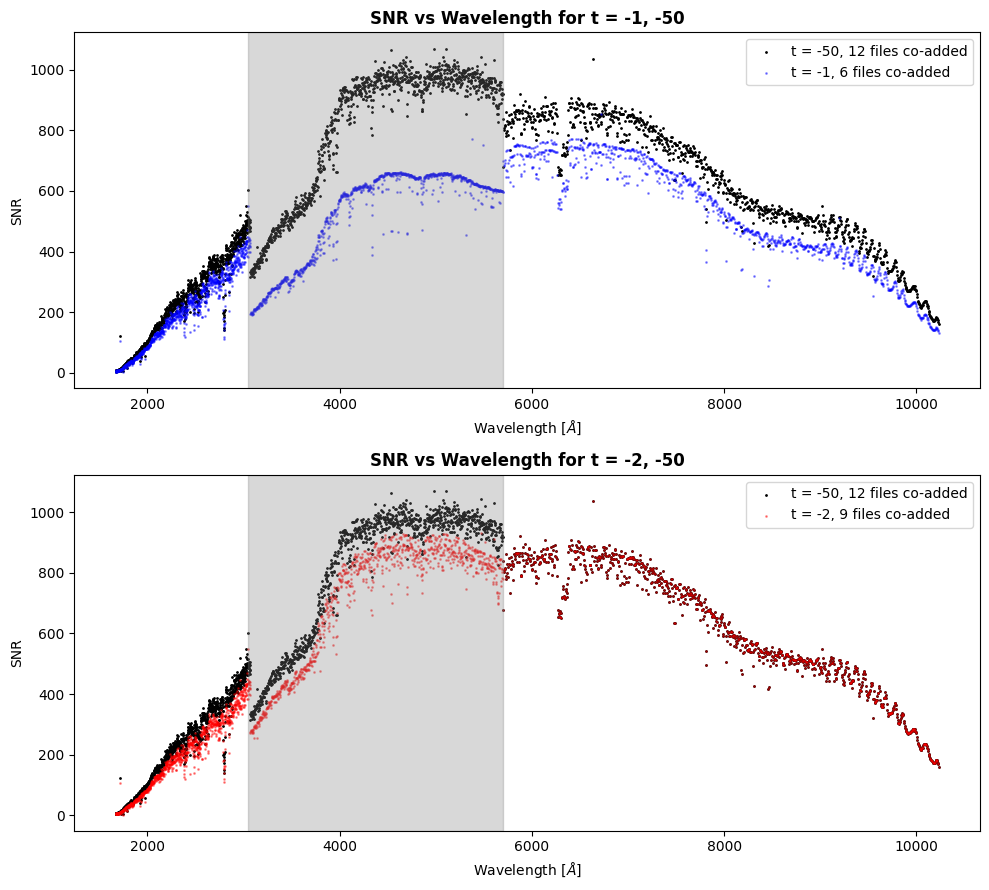

In [34]:
%matplotlib inline
# A list of the the non-default thresholds used.
nondefault_thresholds = [thresh for thresh in thresholds if thresh != "-50"]

# List of colors to be used when plotting
colors = ['blue',
          'red']

# Creating our figure: 1 column and len(thresholds) rows
figure, ax = plt.subplots(len(nondefault_thresholds), 1,
                          figsize=(10, 9))

# Iterating through threshold values to compare their SNR to default output
for i, thresh in enumerate(nondefault_thresholds):

    # The SNR and wavelength data for the default threshold co-add output
    default_path = f"{bd_products_dir}/out-50/{bd_coadd_name}"
    default_hdul = fits.open(default_path)
    data50 = default_hdul[1].data
    wavelength50 = data50["WAVELENGTH"]
    snr50 = data50["SNR"]

    # Getting wavelength and SNR for the current iteration's threshold value
    curr_path = f"{bd_products_dir}/out{thresh}/{bd_coadd_name}"
    curr_hdul = fits.open(curr_path)
    data = curr_hdul[1].data
    wavelength = data["WAVELENGTH"]
    snr = data["SNR"]

    # This is the number of files used in the particular co-add
    numfiles = len(fits.open(curr_path)[2].data["FILENAME"])
    numfiles_default = len(fits.open(default_path)[2].data["FILENAME"])

    ax[i].scatter(wavelength50, snr50,
                  label=f"t = -50, {numfiles_default} files co-added",
                  s=1,
                  color="black")

    ax[i].scatter(wavelength, snr,
                  label=f"t = {thresh}, {numfiles} files co-added",
                  color=colors[i],
                  s=1,
                  alpha=0.4)

    ax[i].legend()

    # Highlighting the region of the plot with the biggest SNR change
    ax[i].axvspan(3050, 5700,
                  alpha=0.3,
                  color="grey")

    # Adding formatting
    ax[i].set_title(f"SNR vs Wavelength for t = {thresh}, -50",
                    weight="bold")
    ax[i].set_xlabel(r'Wavelength [$\AA$]')
    ax[i].set_ylabel("SNR")

    default_hdul.close()
    curr_hdul.close()

figure.tight_layout()

# Saving the figure to ./bd_products
figure.savefig(f"{bd_products_dir}/snr_wavelength.png")

We can clearly see above that using more files in the co-add substantially increases SNR. This is especially prevalent in the grey highlighted section of the top plot, where we set `t = -1`. The number of files used with that threshold value were 6 files, whereas the default threshold value of `t = -50` used 12 files.

### Looking at Flux:
We're going to create two diffrent plots to analyze our flux data: a standard flux vs wavelength plot, and a differential plot. We will also calculate the percent change in flux between the threshold values vs the default.

A differential plot shows the absolute differences between two datasets; in our case, we will be seeing the flux difference at each wavelength between one threshold value's co-add and the default co-add. However, we will first need to interpolate the spectra to a common wavelength grid. Essentially, we will be adjusting the wavelength values so the two datasets can share the same wavelength points. 

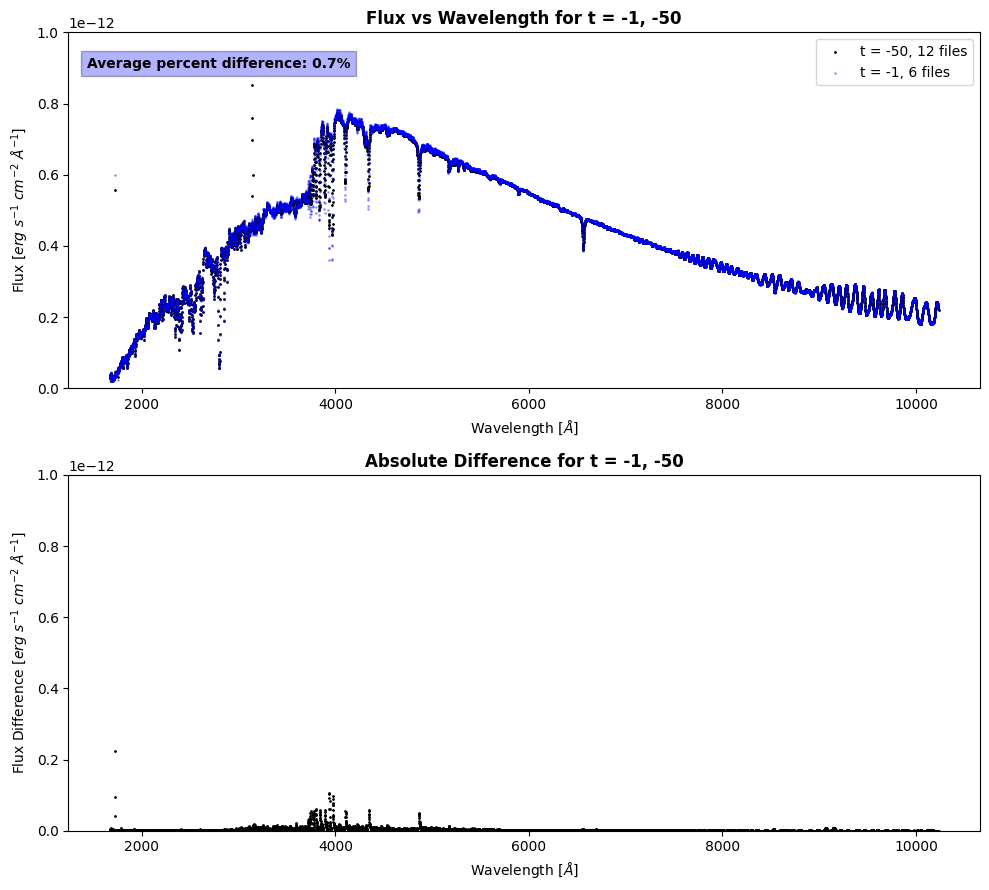

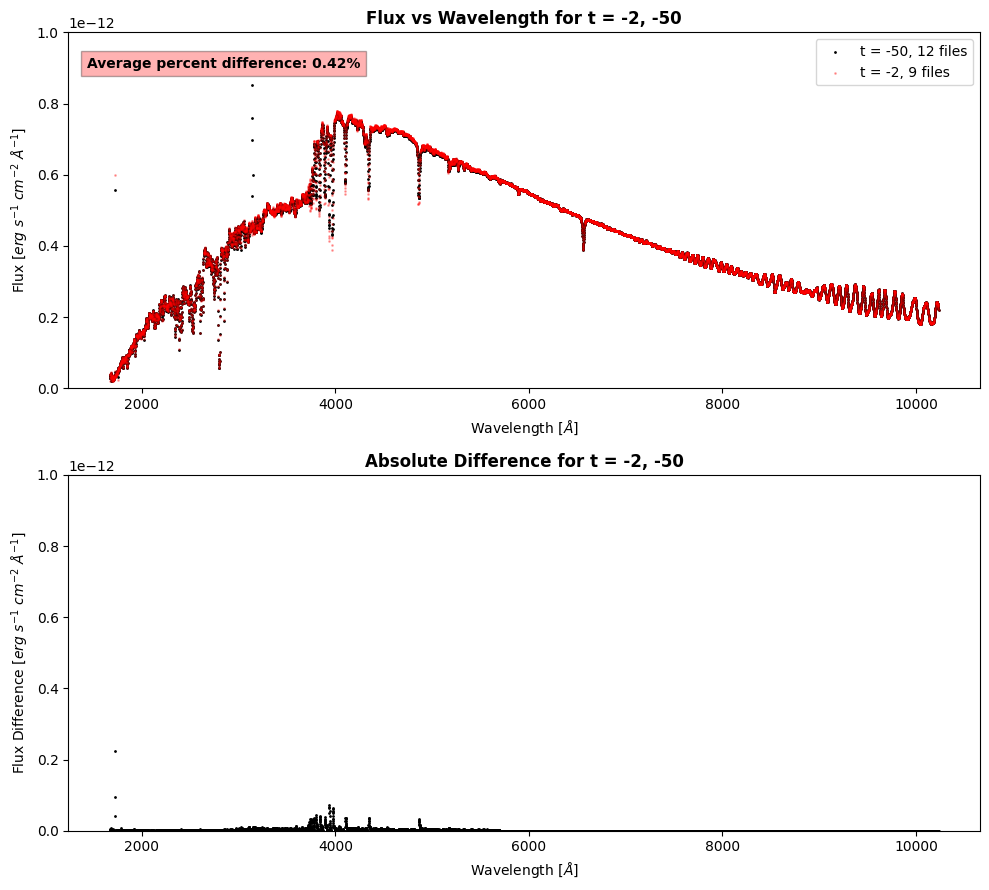

In [35]:
# Thresholds used that aren't the default
nondefault_thresholds = [thresh for thresh in thresholds if thresh != "-50"]

for i, thresh in enumerate(nondefault_thresholds):
    # Getting the data for the co-add that uses default threshold of t = -50
    default_path = f"{bd_products_dir}/out-50/{bd_coadd_name}"
    default_hdul = fits.open(default_path)
    thresh_data50 = default_hdul[1].data

    wavelength50 = thresh_data50["WAVELENGTH"]
    flux50 = thresh_data50["FLUX"]

    # Getting data for the co-add that uses the current iteration's threshold
    curr_path = f"{bd_products_dir}/out{thresh}/{bd_coadd_name}"
    curr_hdul = fits.open(curr_path)
    thresh_data_curr = curr_hdul[1].data

    wavelength_curr = thresh_data_curr["WAVELENGTH"]
    flux_curr = thresh_data_curr["FLUX"]

    # Getting the number of files used in co-add, will put this in the plot
    numfiles = len(fits.open(curr_path)[2].data["FILENAME"])
    numfiles_default = len(fits.open(default_path)[2].data["FILENAME"])

    # Minimum wavelength value in dataset
    minwave = min(wavelength50[0].min(), wavelength_curr[0].min())

    # Maximum wavelength value in dataset
    maxwave = max(wavelength50[0].max(), wavelength_curr[0].max())

    # Creating a common wavelength grid using shape of default wavelength axis
    common_wavelength = np.arange(start=minwave,
                                  stop=maxwave,
                                  step=1)

    # Interpolating the default + current threshold co-add onto new grid
    interp_flux50 = interp1d(wavelength50[0],
                             flux50,
                             kind='linear',
                             fill_value="extrapolate")(common_wavelength)
    
    interp_flux_curr = interp1d(wavelength_curr[0],
                                flux_curr,
                                kind='linear',
                                fill_value="extrapolate")(common_wavelength)

    # Creating two subplots, one flux vs wavelength and one differential plot
    fig, [ax0, ax1] = plt.subplots(2, 1,
                                   figsize=(10, 9))

    # Plotting the top plot, a.k.a. the flux vs wavelength for t = -50
    ax0.scatter(common_wavelength, interp_flux50,
                label=f"t = -50, {numfiles_default} files",
                color="black",
                s=1)

    # Plotting flux vs wavelength on same plot for current co-add
    ax0.scatter(common_wavelength, interp_flux_curr,
                label=f"t = {thresh}, {numfiles} files",
                color=colors[i],
                s=1,
                alpha=0.3)

    # Calculating difference between current co-add and default flux values
    flux_diff = interp_flux_curr - interp_flux50

    # Plotting the differential plot
    ax1.scatter(common_wavelength, flux_diff,
                color="black",
                s=1)

    # Calculating the percent difference and putting it on the plot
    percent_difference = abs(interp_flux50 - interp_flux_curr) / ((interp_flux50 + interp_flux_curr) / 2) * 100

    # Calculating the mean percent difference (ignoring NaNs)
    percent_difference = round(np.nanmean(percent_difference), 2)

    # Adding text box onto plot that displays newly calculated 5 difference
    ax0.text(0.02, 0.9,
             f"Average percent difference: {str(percent_difference)}%",
             transform=ax0.transAxes,
             weight="bold",
             bbox=dict(facecolor=colors[i],
                       alpha=0.3))
    
    # Setting the y axis limits on both plots to be the same
    ax0.set_ylim(0, 1e-12)
    ax1.set_ylim(0, 1e-12)

    # Adding formatting
    ax0.set_title(f"Flux vs Wavelength for t = {thresh}, -50",
                  weight="bold")

    ax0.set_xlabel(r'Wavelength [$\AA$]')
    ax0.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    # Putting the legend on the flux plot
    ax0.legend()

    ax1.set_title(f"Absolute Difference for t = {thresh}, -50",
                  weight="bold")
    
    ax1.set_xlabel(r'Wavelength [$\AA$]')
    ax1.set_ylabel(r'Flux Difference [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    fig.tight_layout()

    fig.savefig(f"{bd_products_dir}/flux_differential.png")

    fig.show()

    default_hdul.close()
    curr_hdul.close()

# Congrats on completing the notebook!

### There are more tutorial notebooks for custom co-addition cases in [this repo](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP), check them out!

## About this Notebook
**Author:** Sierra Gomez (sigomez@stsci.edu)

**Updated on:** 01/29/2024

*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*


## Citations

If you use the following packages for published research, please cite the authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)

* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)

* [Citing `numpy`](https://numpy.org/citing-numpy/)

* [Citing `scipy`](https://scipy.org/citing-scipy/)

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>